Spike 2 to wav


In [1]:
import os
import numpy as np
from scipy import signal
import soundfile as sf
from neo.io import CedIO
from tqdm import tqdm

# ─── User Parameters ────────────────────────────────────────
INPUT_DIR   = 'nerve_data_smr'       # root folder with .smr in species subfolders
OUTPUT_ROOT = 'Wav_data_all'         # top‐level output folder

CHANNEL_IDX = 0
SEGMENT_IDX = 0

MIN_FREQ    = 0      # Hz
MAX_FREQ    = 1000   # Hz
ORDER       = 4      # filter order

# ─── Your stroke time‐ranges (seconds) ──────────────────────
# for fs=100 000 Hz, these correspond to samples [10000–110000], etc.
RANGES_SEC = {
    'forward': [
        (0.00, 1.05),
        (1.10, 2.15),
    ],
    'backward': [
        (2.50, 3.55),
        (3.60, 4.70),
    ],
}

def process_file(full_path):
    base     = os.path.splitext(os.path.basename(full_path))[0]
    rel_dir  = os.path.relpath(os.path.dirname(full_path), INPUT_DIR)
    species  = rel_dir.split(os.sep)[0]  # top‐level folder under INPUT_DIR

    # build species folder
    species_dir = os.path.join(OUTPUT_ROOT, species)
    os.makedirs(species_dir, exist_ok=True)

    # 1. Load data
    reader = CedIO(filename=full_path)
    block  = reader.read_block(lazy=False)
    seg    = block.segments[SEGMENT_IDX]
    analog = seg.analogsignals[CHANNEL_IDX]
    data   = np.array(analog).flatten()
    fs     = 100000  # Hz

    # 2. Design & apply filter
    nyq = fs / 2.0
    if MIN_FREQ <= 0:
        b, a = signal.butter(ORDER, MAX_FREQ/nyq, btype='low')
    else:
        b, a = signal.butter(ORDER,
                            [MIN_FREQ/nyq, MAX_FREQ/nyq],
                            btype='band')
    filtered = signal.filtfilt(b, a, data)
    # normalize
    filtered = filtered / np.max(np.abs(filtered))

    # 3. Split & save
    for direction, windows in RANGES_SEC.items():
        out_dir = os.path.join(species_dir, direction)
        os.makedirs(out_dir, exist_ok=True)

        for idx, (t0, t1) in enumerate(windows, start=1):
            s0 = int(t0 * fs)
            s1 = int(t1 * fs)
            segment = filtered[s0:s1]
            out_name = f"{base}_{direction}_{idx}.wav"
            out_path = os.path.join(out_dir, out_name)
            sf.write(out_path, segment, fs, subtype='FLOAT')
            print(f"[+] Saved {direction} #{idx}: {out_path}")

def main():
    os.makedirs(OUTPUT_ROOT, exist_ok=True)

    if not os.path.isdir(INPUT_DIR):
        raise FileNotFoundError(f"Directory not found: {INPUT_DIR}")

    for root, _, files in os.walk(INPUT_DIR):
        for fname in files:
            if fname.lower().endswith('.smr'):
                process_file(os.path.join(root, fname))

if __name__ == '__main__':
    main()

[+] Saved forward #1: Wav_data_all\aedes aegypti\forward\030724_Liverpool_male_mos1_253deg_LSwAv_1_forward_1.wav
[+] Saved forward #2: Wav_data_all\aedes aegypti\forward\030724_Liverpool_male_mos1_253deg_LSwAv_1_forward_2.wav
[+] Saved backward #1: Wav_data_all\aedes aegypti\backward\030724_Liverpool_male_mos1_253deg_LSwAv_1_backward_1.wav
[+] Saved backward #2: Wav_data_all\aedes aegypti\backward\030724_Liverpool_male_mos1_253deg_LSwAv_1_backward_2.wav
[+] Saved forward #1: Wav_data_all\aedes aegypti\forward\030724_Liverpool_male_mos1_253deg_LSwAv_11_forward_1.wav
[+] Saved forward #2: Wav_data_all\aedes aegypti\forward\030724_Liverpool_male_mos1_253deg_LSwAv_11_forward_2.wav
[+] Saved backward #1: Wav_data_all\aedes aegypti\backward\030724_Liverpool_male_mos1_253deg_LSwAv_11_backward_1.wav
[+] Saved backward #2: Wav_data_all\aedes aegypti\backward\030724_Liverpool_male_mos1_253deg_LSwAv_11_backward_2.wav
[+] Saved forward #1: Wav_data_all\aedes aegypti\forward\030724_Liverpool_male_m

Plotting wav

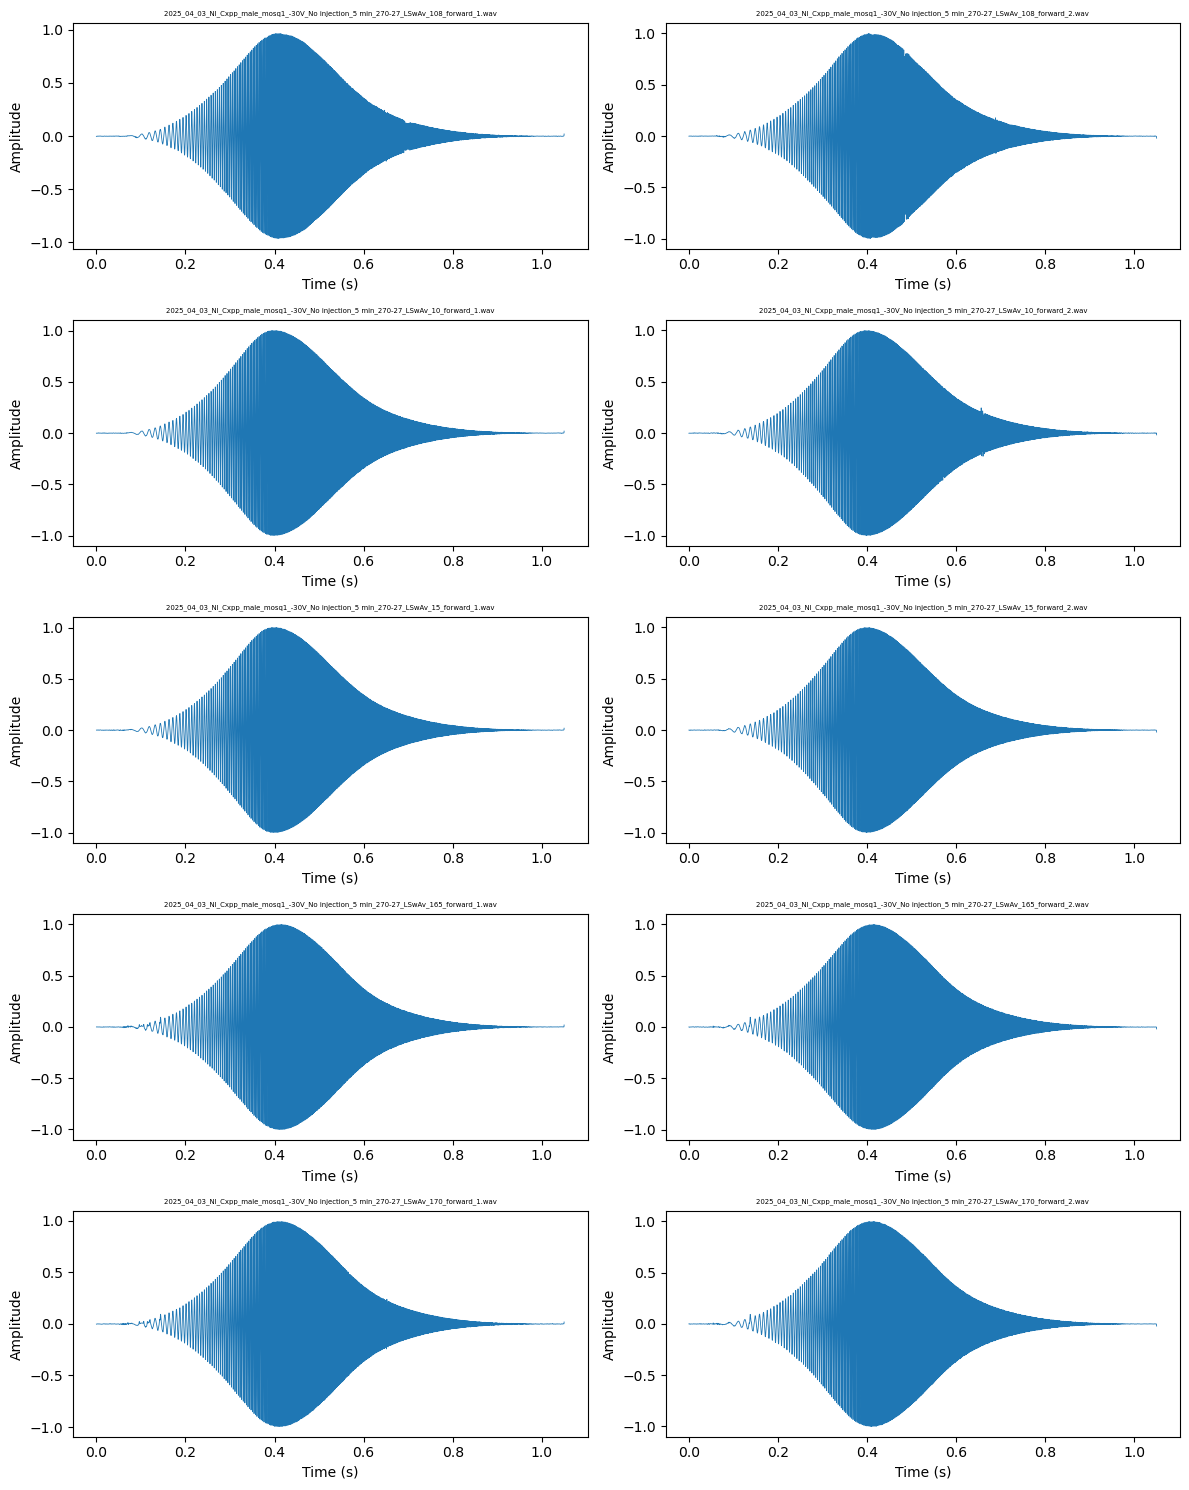

In [2]:
import os
import glob
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

# 1) Grab first 10 forward WAVs from Culex
forward_dir = os.path.join("Wav_data_all", "Culex", "forward")
wav_paths   = sorted(glob.glob(os.path.join(forward_dir, "*.wav")))[:10]

# 2) Set up a 5×2 grid
fig, axes = plt.subplots(5, 2, figsize=(12, 15))
axes = axes.flatten()

# 3) Loop & plot
for ax, wav in zip(axes, wav_paths):
    y, sr = sf.read(wav)
    t = np.arange(len(y)) / sr
    ax.plot(t, y, linewidth=0.6)
    ax.set_title(os.path.basename(wav), fontsize=5)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")

# 4) Turn off any unused subplots
for ax in axes[len(wav_paths):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [3]:
import os
import glob
import numpy as np
import pandas as pd
import soundfile as sf

def get_peak_frequency(forward_dir):
    y, fs = sf.read(forward_dir)
    # In case of stereo, select the first channel
    if y.ndim > 1:
        y = y[:, 0]
    n = len(y)
    fft_data = np.fft.fft(y)
    fft_magnitude = np.abs(fft_data[: n // 2])
    freqs = np.fft.fftfreq(n, d=1/fs)[: n // 2]
    peak_index = np.argmax(fft_magnitude)
    peak_freq = freqs[peak_index]
    peak_mag = fft_magnitude[peak_index]
    return peak_freq, peak_mag

# Specify the directory for forward Culex WAV files
forward_dir = os.path.join("Wav_data_all", "Culex", "forward")
wav_files = sorted(glob.glob(os.path.join(forward_dir, "*.wav")))

records = []
for wav in wav_files:
    peak_freq, peak_mag = get_peak_frequency(wav)
    records.append({
        "filename": os.path.basename(wav),
        "peak_freq": peak_freq,
        "peak_mag": peak_mag
    })

df_peaks = pd.DataFrame(records)
print(df_peaks)

                                              filename   peak_freq  \
0    2025_04_03_NI_Cxpp_male_mosq1_-30V_No injectio...  369.523810   
1    2025_04_03_NI_Cxpp_male_mosq1_-30V_No injectio...  360.952381   
2    2025_04_03_NI_Cxpp_male_mosq1_-30V_No injectio...  347.619048   
3    2025_04_03_NI_Cxpp_male_mosq1_-30V_No injectio...  343.809524   
4    2025_04_03_NI_Cxpp_male_mosq1_-30V_No injectio...  346.666667   
..                                                 ...         ...   
167  2025_04_04_NI_Cxpp_male_mosq3_-30V_No injectio...  427.619048   
168  2025_04_04_NI_Cxpp_male_mosq3_-30V_No injectio...  439.047619   
169  2025_04_04_NI_Cxpp_male_mosq3_-30V_No injectio...  432.380952   
170  2025_04_04_NI_Cxpp_male_mosq3_-30V_No injectio...  443.809524   
171  2025_04_04_NI_Cxpp_male_mosq3_-30V_No injectio...  418.095238   

        peak_mag  
0    1526.576590  
1    1590.801185  
2    1588.327204  
3    1589.452323  
4    1587.322448  
..           ...  
167  1581.051841  
168  15

Wav to mfcc

In [4]:
import os
import glob
import logging
import numpy as np
import pandas as pd
import soundfile as sf
import librosa

def setup_logger(level=logging.INFO):
    fmt = "[%(asctime)s] %(levelname)s: %(message)s"
    logging.basicConfig(level=level, format=fmt)

def compute_and_save_mfcc(wav_path, raw_out_dir, n_mfcc=13):
    try:
        y, sr = sf.read(wav_path)
    except Exception as e:
        logging.error(f"Failed to read {wav_path}: {e}")
        return None

    # Compute mel spectrogram limited to 0–1000 Hz
    mel = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=128,
        fmin=0,
        fmax=1000
    )
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=n_mfcc)[1:]

    mfcc_mean = mfcc.mean(axis=1)
    mfcc_std  = mfcc.std(axis=1)

    base = os.path.splitext(os.path.basename(wav_path))[0]
    os.makedirs(raw_out_dir, exist_ok=True)
    np.save(os.path.join(raw_out_dir, f"{base}_mfcc.npy"), mfcc)
    return mfcc_mean, mfcc_std

def compute_mfcc_for_culex_forward(input_root="Wav_data_all", output_root="MFCC_data", n_mfcc=13, verbose=False):
    setup_logger(logging.DEBUG if verbose else logging.INFO)
    
    pattern = os.path.join(input_root, "Culex", "forward", "*.wav")
    wav_files = glob.glob(pattern)
    if not wav_files:
        logging.warning(f"No WAV files found in {pattern}")
        return

    species = "Culex"
    direction = "forward"
    logging.info(f"Starting MFCC extraction for {species}/{direction}")

    species_dir = os.path.join(output_root, species, direction)
    raw_dir = os.path.join(species_dir, "mfcc_raw")
    os.makedirs(raw_dir, exist_ok=True)

    summary_records = []
    for wav_path in wav_files:
        filename = os.path.basename(wav_path)
        logging.info(f"  Processing {species}/{direction}/{filename}")
        result = compute_and_save_mfcc(wav_path, raw_dir, n_mfcc=n_mfcc)
        if result is None:
            continue
        mfcc_mean, mfcc_std = result

        record = {
            "species": species,
            "direction": direction,
            "filename": filename
        }
        for i, m in enumerate(mfcc_mean, start=2):
            record[f"mfcc{i}_mean"] = m
        for i, s in enumerate(mfcc_std, start=2):
            record[f"mfcc{i}_std"] = s
        summary_records.append(record)

    df = pd.DataFrame(summary_records)
    csv_out = os.path.join(species_dir, f"mfcc_summary_{species}_{direction}.csv")
    df.to_csv(csv_out, index=False)
    logging.info(f"[+] Wrote summary CSV for {species}/{direction}: {csv_out}")

# Run it
compute_mfcc_for_culex_forward(verbose=True)


[2025-07-07 18:36:43,380] INFO: Starting MFCC extraction for Culex/forward
[2025-07-07 18:36:43,380] INFO:   Processing Culex/forward/2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection_5 min_270-27_LSwAv_108_forward_1.wav
c:\Users\alber\anaconda3\envs\sound_analysis\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
[2025-07-07 18:36:43,392] INFO:   Processing Culex/forward/2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection_5 min_270-27_LSwAv_108_forward_2.wav
[2025-07-07 18:36:43,399] INFO:   Processing Culex/forward/2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection_5 min_270-27_LSwAv_10_forward_1.wav
[2025-07-07 18:36:43,406] INFO:   Processing Culex/forward/2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection_5 min_270-27_LSwAv_10_forward_2.wav
[2025-07-07 18:36:43,413] INFO:   Processing Culex/forward/2

checking shape of mfcc

In [5]:
import os
import glob
import numpy as np

# Path to folder with saved MFCC arrays
mfcc_dir = "MFCC_data/Culex/forward/mfcc_raw"

# Find all .npy files
mfcc_files = sorted(glob.glob(os.path.join(mfcc_dir, "*.npy")))

# Print shapes of each
for path in mfcc_files:
    arr = np.load(path)
    print(f"{os.path.basename(path)}: {arr.shape}")


2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection_5 min_270-27_LSwAv_0_forward_1_mfcc.npy: (12, 196)
2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection_5 min_270-27_LSwAv_0_forward_2_mfcc.npy: (12, 196)
2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection_5 min_270-27_LSwAv_103_forward_1_mfcc.npy: (12, 196)
2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection_5 min_270-27_LSwAv_103_forward_2_mfcc.npy: (12, 196)
2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection_5 min_270-27_LSwAv_108_forward_1_mfcc.npy: (12, 206)
2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection_5 min_270-27_LSwAv_108_forward_2_mfcc.npy: (12, 206)
2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection_5 min_270-27_LSwAv_10_forward_1_mfcc.npy: (12, 206)
2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection_5 min_270-27_LSwAv_10_forward_2_mfcc.npy: (12, 206)
2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection_5 min_270-27_LSwAv_113_forward_1_mfcc.npy: (12, 196)
2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection_5 min_270-27_LSwAv_113_forward_2_mfcc.npy: (12, 1

Plotting mffc


[2025-07-07 18:36:46,575] DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x000001605D090190>
[2025-07-07 18:36:46,647] DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
[2025-07-07 18:36:46,647] DEBUG: findfont: score(FontEntry(fname='c:\\Users\\alber\\anaconda3\\envs\\sound_analysis\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2025-07-07 18:36:46,647] DEBUG: findfont: score(FontEntry(fname='c:\\Users\\alber\\anaconda3\\envs\\sound_analysis\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[2025-07-07 18:36:46,647] DEBUG: findfont: score(FontEntry(fname='c:\\Users\\alber\\anaconda3\\envs\\sound_analysis\\lib\\site-packages\\mat

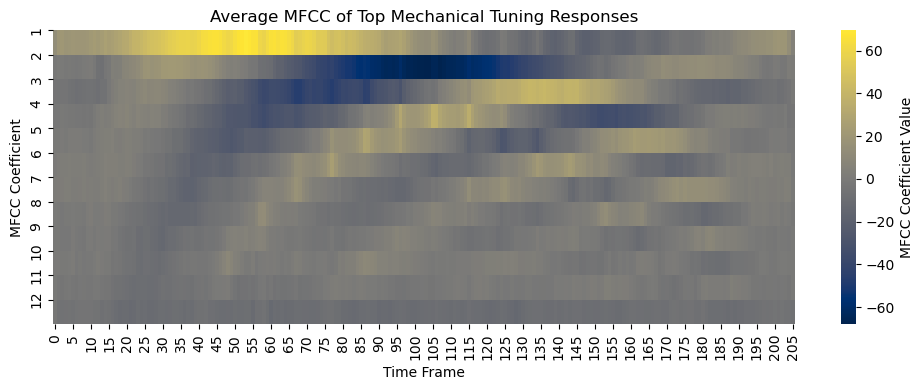

DataFrame: Top 10 Strongest MFCC Responses
  species direction                                           filename  \
0   Culex   forward  2025_04_03_NI_Cxpp_male_mosq1_-30V_No injectio...   
1   Culex   forward  2025_04_03_NI_Cxpp_male_mosq1_-30V_No injectio...   
2   Culex   forward  2025_04_03_NI_Cxpp_male_mosq1_-30V_No injectio...   
3   Culex   forward  2025_04_03_NI_Cxpp_male_mosq1_-30V_No injectio...   
4   Culex   forward  2025_04_03_NI_Cxpp_male_mosq1_-30V_No injectio...   

   mfcc2_mean  mfcc3_mean  mfcc4_mean  mfcc5_mean  mfcc6_mean  mfcc7_mean  \
0   18.742450  -16.336228   -2.151414   -6.512694   -0.622531   -0.786952   
1   18.388705  -16.779526   -2.427917   -5.751736   -0.480743   -0.633237   
2   18.285818  -15.163049   -3.387501   -6.611641   -0.534049   -0.781366   
3   19.905827  -15.336085   -4.496453   -7.407537   -0.368590   -0.303512   
4   18.127134  -15.548144   -3.522554   -6.499267   -0.491961   -0.967835   

   mfcc8_mean  ...  mfcc5_std  mfcc6_std  mfcc7_s

In [6]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the path to your MFCC data
mfcc_dir = "MFCC_data/Culex/forward/mfcc_raw"
summary_csv = "MFCC_data/Culex/forward/mfcc_summary_Culex_forward.csv"

# Load summary CSV
summary_df = pd.read_csv(summary_csv)

# Compute a "response strength" proxy: mean of mfcc1 or total RMS energy
summary_df["response_strength"] = summary_df["mfcc2_mean"]  # using mfcc1_mean as proxy

# Sort by strongest responses
top_responses = summary_df.sort_values("response_strength", ascending=False).head(10)

# Load the corresponding MFCC .npy files
mfcc_matrices = []
file_names = []
for fname in top_responses["filename"]:
    base = os.path.splitext(fname)[0]
    npy_path = os.path.join(mfcc_dir, f"{base}_mfcc.npy")
    if os.path.exists(npy_path):
        mfcc = np.load(npy_path)
        mfcc_matrices.append(mfcc)
        file_names.append(fname)

# Compute mean MFCC over top responses
mean_mfcc = np.mean(mfcc_matrices, axis=0)

# Plot the average MFCC pattern
plt.figure(figsize=(10, 4))
sns.heatmap(mean_mfcc, cmap="cividis", cbar_kws={"label": "MFCC Coefficient Value"})
plt.title("Average MFCC of Top Mechanical Tuning Responses")
plt.xlabel("Time Frame")
plt.yticks(ticks=np.arange(mean_mfcc.shape[0]), labels=[f"{i}" for i in range(1, mean_mfcc.shape[0] + 1)])
plt.ylabel("MFCC Coefficient")
plt.tight_layout()
plt.show()

# A simple alternative to tools.display_dataframe_to_user
def display_dataframe_to_user(name, dataframe):
    print(f"DataFrame: {name}")
    print(dataframe.head())
    
# Then replace the call:
display_dataframe_to_user("Top 10 Strongest MFCC Responses", summary_df)

[2025-07-07 18:36:46,969] DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x000001605D73C3A0>


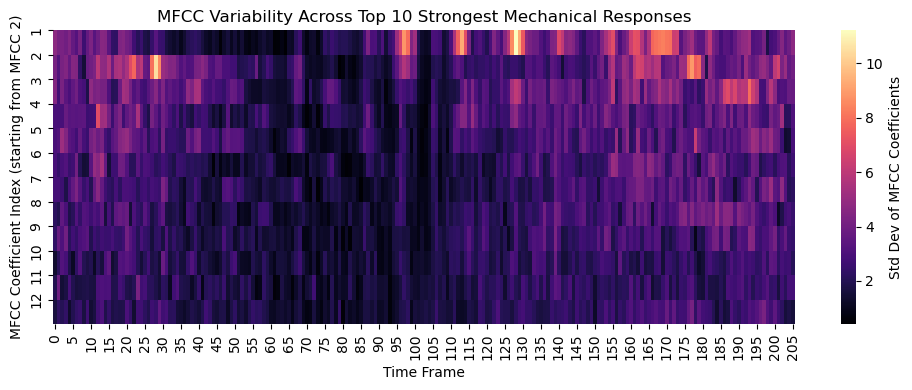

In [7]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the summary CSV (already sorted top responses with response_strength)
summary_csv = "MFCC_data/Culex/forward/mfcc_summary_Culex_forward.csv"
summary_df = pd.read_csv(summary_csv)

# Use mfcc2_mean as proxy for response strength (since mfcc1 was removed)
summary_df["response_strength"] = summary_df["mfcc2_mean"]

# Get top 10 strongest responses
top_responses = summary_df.sort_values("response_strength", ascending=False).head(10)

# Path to the .npy raw MFCC arrays
mfcc_dir = "MFCC_data/Culex/forward/mfcc_raw"

# Load corresponding MFCC arrays
mfcc_matrices = []
for fname in top_responses["filename"]:
    base = os.path.splitext(fname)[0]
    npy_path = os.path.join(mfcc_dir, f"{base}_mfcc.npy")
    if os.path.exists(npy_path):
        mfcc = np.load(npy_path)
        mfcc_matrices.append(mfcc)

# Stack and compute std across samples (axis=0)
mfcc_array = np.stack(mfcc_matrices, axis=0)  # shape: (10, 12, T)
mfcc_std = np.std(mfcc_array, axis=0)         # shape: (12, T)

# Plot the heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(mfcc_std, cmap="magma", cbar_kws={"label": "Std Dev of MFCC Coefficients"})
plt.yticks(ticks=np.arange(mean_mfcc.shape[0]), labels=[f"{i}" for i in range(1, mean_mfcc.shape[0] + 1)])
plt.title("MFCC Variability Across Top 10 Strongest Mechanical Responses")
plt.xlabel("Time Frame")
plt.ylabel("MFCC Coefficient Index (starting from MFCC 2)")
plt.tight_layout()
plt.show()


In [2]:
# Cell 1: Extract and merge features with Dask

import os
import glob
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
import dask
from dask import delayed
from dask.distributed import Client

# Start Dask client
client = Client()

# Helper functions
def get_peak_frequency(path):
    y, fs = sf.read(path)
    if y.ndim > 1: y = y[:,0]
    N = len(y)
    mag = np.abs(np.fft.fft(y)[:N//2])
    freqs = np.fft.fftfreq(N, d=1/fs)[:N//2]
    return freqs[np.argmax(mag)]

def compute_rms_energy(y):
    return np.sqrt(np.mean(y**2))

def compute_spectral_features(y, sr):
    c = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    b = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    f = librosa.feature.spectral_flatness(y=y)[0]
    return np.mean(c), np.mean(b), np.mean(f)

def compute_autocorrelation(y):
    ac = np.correlate(y, y, mode='full')
    ac = ac[len(ac)//2:]
    return np.max(ac)

def compute_wave_magnitude(y):
    return np.max(np.abs(y))

@delayed
def process_wav_file(path):
    peak = get_peak_frequency(path)
    y, sr = sf.read(path)
    rms = compute_rms_energy(y)
    sc, sb, sf_ = compute_spectral_features(y, sr)
    ac = compute_autocorrelation(y)
    mag = compute_wave_magnitude(y)
    return {
        'filename': os.path.basename(path),
        'peak_freq': peak,
        'rms_energy': rms,
        'spectral_centroid': sc,
        'spectral_bandwidth': sb,
        'spectral_flatness': sf_,
        'autocorr': ac,
        'wave_magnitude': mag
    }

# Load MFCC summary
mfcc_csv = "MFCC_data/Culex/forward/mfcc_summary_Culex_forward.csv"
df_mfcc = pd.read_csv(mfcc_csv)

# Process WAV files
wav_dir = os.path.join("Wav_data_all", "Culex", "forward")
wav_files = sorted(glob.glob(os.path.join(wav_dir, "*.wav")))
records = dask.compute(*[process_wav_file(w) for w in wav_files])
df_peaks = pd.DataFrame(records)

# Merge and save processed features
df_features = pd.concat([
    df_mfcc,
    df_peaks[['peak_freq','rms_energy','spectral_centroid',
              'spectral_bandwidth','spectral_flatness',
              'autocorr','wave_magnitude']]
], axis=1)
df_features.to_csv("processed_features_dask.csv", index=False)

client.close()


In [5]:
import pandas as pd

# Load the processed features
df = pd.read_csv("processed_features_dask.csv")

# Compute and print the overall mean of mfcc2_mean
mfcc2_mean_value = df["mfcc2_mean"].mean()
print(f"Average mfcc2_mean across all samples: {mfcc2_mean_value:.4f}")


Average mfcc2_mean across all samples: 13.3053


R² for peak_freq: 0.88
R² for rms_energy: 0.69
R² for spectral_centroid: 0.25
R² for spectral_bandwidth: 0.04
R² for spectral_flatness: 0.52
R² for autocorr: 0.46
R² for wave_magnitude: 0.23

Top 10 features overall (MFCC only):
mfcc2_mean     0.218230
mfcc4_std      0.093225
mfcc11_std     0.065792
mfcc12_mean    0.056287
mfcc4_mean     0.052504
mfcc10_mean    0.048300
mfcc11_mean    0.044860
mfcc6_std      0.043755
mfcc9_mean     0.039666
mfcc10_std     0.033675
Name: overall_mean, dtype: float32

Top 5 features per target:

peak_freq:
mfcc2_mean    0.305702
mfcc4_mean    0.189216
mfcc9_mean    0.157593
mfcc6_std     0.078726
mfcc5_mean    0.070136
Name: peak_freq, dtype: float32

rms_energy:
mfcc4_std      0.252050
mfcc12_mean    0.182261
mfcc10_mean    0.096102
mfcc10_std     0.095595
mfcc11_std     0.087172
Name: rms_energy, dtype: float32

spectral_centroid:
mfcc12_mean    0.100984
mfcc2_std      0.061295
mfcc8_mean     0.057257
mfcc9_std      0.055687
mfcc11_std     0.051444
Nam

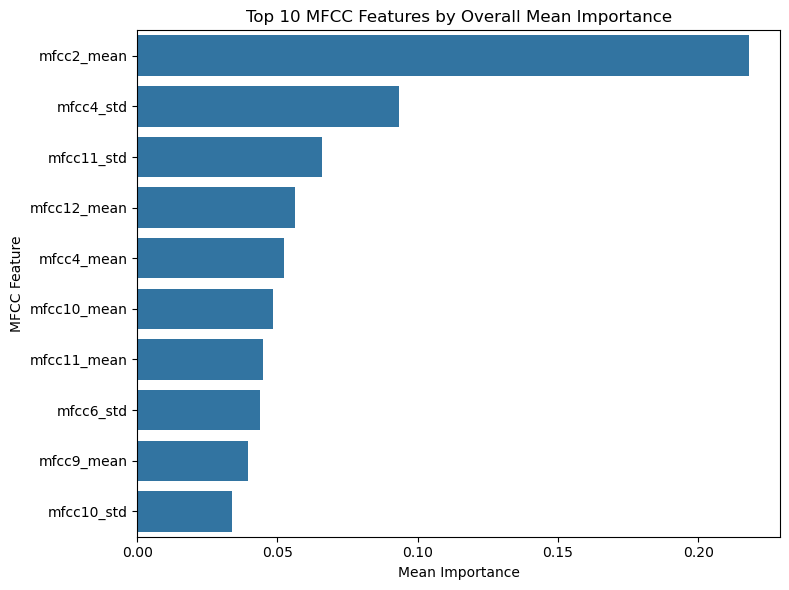

In [4]:
# Cell 2: Train multi-output XGBoost without trivial self-features

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load features (includes MFCCs + your computed targets)
df = pd.read_csv("processed_features_dask.csv")

# 1) Use ONLY MFCCs as predictors
feature_cols = [
    c for c in df.columns
    if ("mfcc" in c and ("_mean" in c or "_std" in c))
]
X = df[feature_cols]

# 2) Keep all original targets, including wave_magnitude, spectral stats, etc.
y = df[[
    "peak_freq",
    "rms_energy",
    "spectral_centroid",
    "spectral_bandwidth",
    "spectral_flatness",
    "autocorr",
    "wave_magnitude"
]]

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) Hyperparameter search setup
param_dist = {
    'n_estimators':    [50, 100, 150],
    'max_depth':       [3, 6, 10],
    'learning_rate':   [0.01, 0.1, 0.3],
    'subsample':       [0.7, 0.8, 1.0],
    'colsample_bytree':[0.7, 0.8, 1.0]
}
random_search = RandomizedSearchCV(
    xgb.XGBRegressor(tree_method='hist', random_state=42),
    param_distributions=param_dist,
    n_iter=10, cv=3, n_jobs=-1, random_state=42
)
multi_model = MultiOutputRegressor(random_search)
multi_model.fit(X_train, y_train)

# 5) Evaluate R² for each target
y_pred = multi_model.predict(X_test)
for i, name in enumerate(y.columns):
    print(f"R² for {name}: {r2_score(y_test.iloc[:,i], y_pred[:,i]):.2f}")

# 6) Gather feature importances per target
imps = [est.best_estimator_.feature_importances_
        for est in multi_model.estimators_]
imps_matrix = np.vstack(imps)
df_imps = pd.DataFrame(
    imps_matrix.T,
    index=feature_cols,
    columns=y.columns
)
df_imps["overall_mean"] = df_imps.mean(axis=1)
df_imps.sort_values("overall_mean", ascending=False, inplace=True)

# 7) Print overall top 10
print("\nTop 10 features overall (MFCC only):")
print(df_imps["overall_mean"].head(10))

# 8) Print top 5 per target
print("\nTop 5 features per target:")
for tgt in y.columns:
    print(f"\n{tgt}:")
    print(df_imps[tgt].nlargest(5))

# 9) Plot overall importances (no palette warning)
top10 = df_imps["overall_mean"].head(10).reset_index().rename(
    columns={"index":"feature", "overall_mean":"importance"}
)
plt.figure(figsize=(8,6))
sns.barplot(
    data=top10,
    x="importance",
    y="feature",
    color="C0"        # use a single color to avoid the palette/hue warning
)
plt.title("Top 10 MFCC Features by Overall Mean Importance")
plt.xlabel("Mean Importance")
plt.ylabel("MFCC Feature")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load features
df = pd.read_csv("processed_features_dask.csv")
mfcc_cols = [c for c in df.columns if c.startswith("mfcc") and "_mean" in c]

# Split and compute training means
X_train, _ = train_test_split(df[mfcc_cols], test_size=0.2, random_state=42)
baseline = X_train.mean()


In [ ]:
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
from scipy.ndimage import gaussian_filter
from scipy.signal import butter, filtfilt

# 1) Same feature → targets steps as before…
#    (compute baseline, stds, feature importances, targets, X_new, pred_rms, etc.)

# --- After step 8: you have `mfcc_mat` and want to invert it smoothly ---

sr      = 44100
n_mels  = 128
n_fft   = 2048
hop     = n_fft // 4
n_iter  = 10000   # more iterations for smoother phase

# 9) Build a Mel spectrogram from your MFCC matrix
mel_db   = librosa.feature.inverse.mfcc_to_mel(mfcc_mat, n_mels=n_mels)
mel_pow  = librosa.db_to_power(mel_db)

# 10) Convert Mel → linear-freq STFT magnitude
stft_mag = librosa.feature.inverse.mel_to_stft(mel_pow, sr=sr, n_fft=n_fft)

# 11) Smooth the magnitude with a small Gaussian blur
stft_mag_smooth = gaussian_filter(stft_mag, sigma=(1, 2))

# 12) Reconstruct phase with more Griffin–Lim iterations
tone = librosa.griffinlim(
    stft_mag_smooth,
    n_iter=n_iter,
    hop_length=hop,
    win_length=n_fft
)

# 13) Optional: low-pass filter to remove residual HF noise
b, a = butter(4, 0.45)  # cutoff at ~0.45 * Nyquist
tone = filtfilt(b, a, tone)

# 14) Apply a gentle fade-in/out envelope (50 ms)
fade_len = int(0.05 * sr)
env = np.ones_like(tone)
env[:fade_len] = np.linspace(0, 1, fade_len)
env[-fade_len:] = np.linspace(1, 0, fade_len)
tone *= env

# 15) Scale to your model’s predicted RMS
current_rms = np.sqrt(np.mean(tone**2))
tone *= (pred_rms / current_rms)

# 16) Save
sf.write("mosquito_lure_smooth.wav", tone, sr)


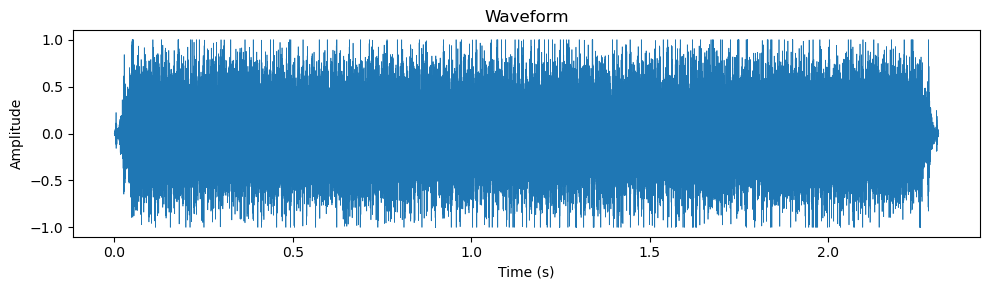

[2025-06-11 17:59:40,031] DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x000001340C943670>


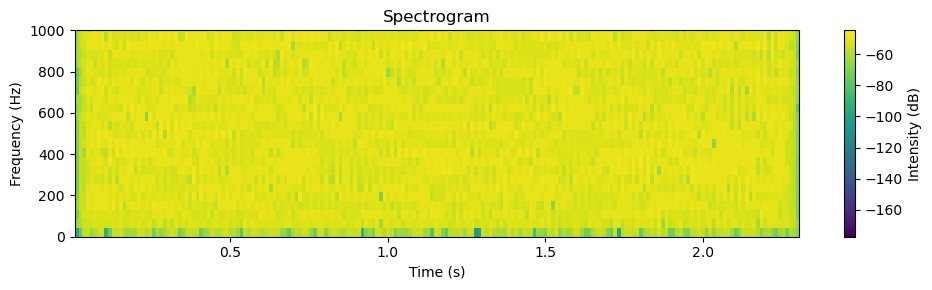

In [ ]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

# 1) Load your generated WAV
y, sr = sf.read("mosquito_lure_smooth.wav")   # ← set your filename here

# 2) Plot the waveform (amplitude vs. time)
t = np.linspace(0, len(y)/sr, len(y))
plt.figure(figsize=(10, 3))
plt.plot(t, y, linewidth=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.tight_layout()
plt.show()

# 3) Plot the spectrogram (frequency content over time)
plt.figure(figsize=(10, 3))
plt.specgram(y, NFFT=1024, Fs=sr, noverlap=512, cmap="viridis")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.ylim(0, 1000)  # Limit to 0–1000 Hz
plt.title("Spectrogram")
plt.colorbar(label="Intensity (dB)")
plt.tight_layout()
plt.show()
